<span style="font-size: 22px;">The task is to create digraph which use some combination of implemented methods.</span>

<span style="font-size: 15px;">Developer task description:</span>
- <span style="font-size: 15px;">create empty digraph.</span>
- <span style="font-size: 15px;">add nodes to digraph - create DAG.</span>
- <span style="font-size: 15px;">create three strongly connected graphs.</span>
- <span style="font-size: 15px;">inject strongly connected graphs to DAG (SSC_3 to SSC_1 before).</span>

In [1]:
import diblob as dib 

#Create digraph without nodes 
digraph = dib.DigraphManager({'DAG': {}})
digraph.add_nodes('A', 'B', 'C', 'D', 'E', 'F')
print(digraph)

{
"DAG": {
    "D": [],
    "B": [],
    "F": [],
    "A": [],
    "C": [],
    "E": [],
},
}



In [2]:
#Add nodes and create DAG
digraph.connect_nodes(('A', 'B'), ('A', 'C'), ('B', 'D'), ('C', 'D'), ('D', 'E'), ('D', 'F'))
print(digraph)

{
"DAG": {
    "D": ["E", "F"],
    "B": ["D"],
    "F": [],
    "A": ["B", "C"],
    "C": ["D"],
    "E": [],
},
}



In [3]:
#Create three strongly connected graphs

# 3-cycle
ssc_1 = dib.DigraphManager({'SSC_1': {'A1': ['B1'],
                                      'B1': ['C1'],
                                      'C1': ['A1']}}) 

# 4-cycle
ssc_2 = dib.DigraphManager({'SSC_2': {'A2': ['B2'],
                                      'B2': ['C2'],
                                      'C2': ['D2'],
                                      'D2': ['A2']}}) 

# 4-cycle with added edge ('A2', 'C2')
ssc_3 = dib.DigraphManager({'SSC_3': {'A3': ['B3', 'C3'],
                                      'B3': ['C3'],
                                      'C3': ['D3'],
                                      'D3': ['A3']}}) 

In [4]:
#Inject 3-cycle to 4-cycle digraph, then inject all digraphs to DAG
ssc_1.inject(ssc_2, 'A1')
digraph.inject(ssc_1, 'B')
digraph.inject(ssc_3, 'C')

In [5]:
print(digraph)

{
"DAG": {
    "D": ["E", "F"],
    "SSC_3": {
        "D3": ["A3", {"DAG": ["D"]}],
        "B3": ["C3", {"DAG": ["D"]}],
        "C3": ["D3", {"DAG": ["D"]}],
        "A3": ["B3", "C3", {"DAG": ["D"]}],
    },
    "SSC_1": {
        "B1": ["C1", {"DAG": ["D"]}],
        "C1": [{"SSC_2": ["A2", "C2", "B2", "D2"]}, {"DAG": ["D"]}],
        "SSC_2": {
            "A2": ["B2", {"SSC_1": ["B1"]}],
            "C2": ["D2", {"SSC_1": ["B1"]}],
            "B2": ["C2", {"SSC_1": ["B1"]}],
            "D2": ["A2", {"SSC_1": ["B1"]}],
        },
    },
    "F": [],
    "A": [{"SSC_1": ["B1", "C1"]}, {"SSC_3": ["D3", "B3", "C3", "A3"]}],
    "E": [],
},
}



<span style="font-size: 17px;">All steps are presented below:</span>

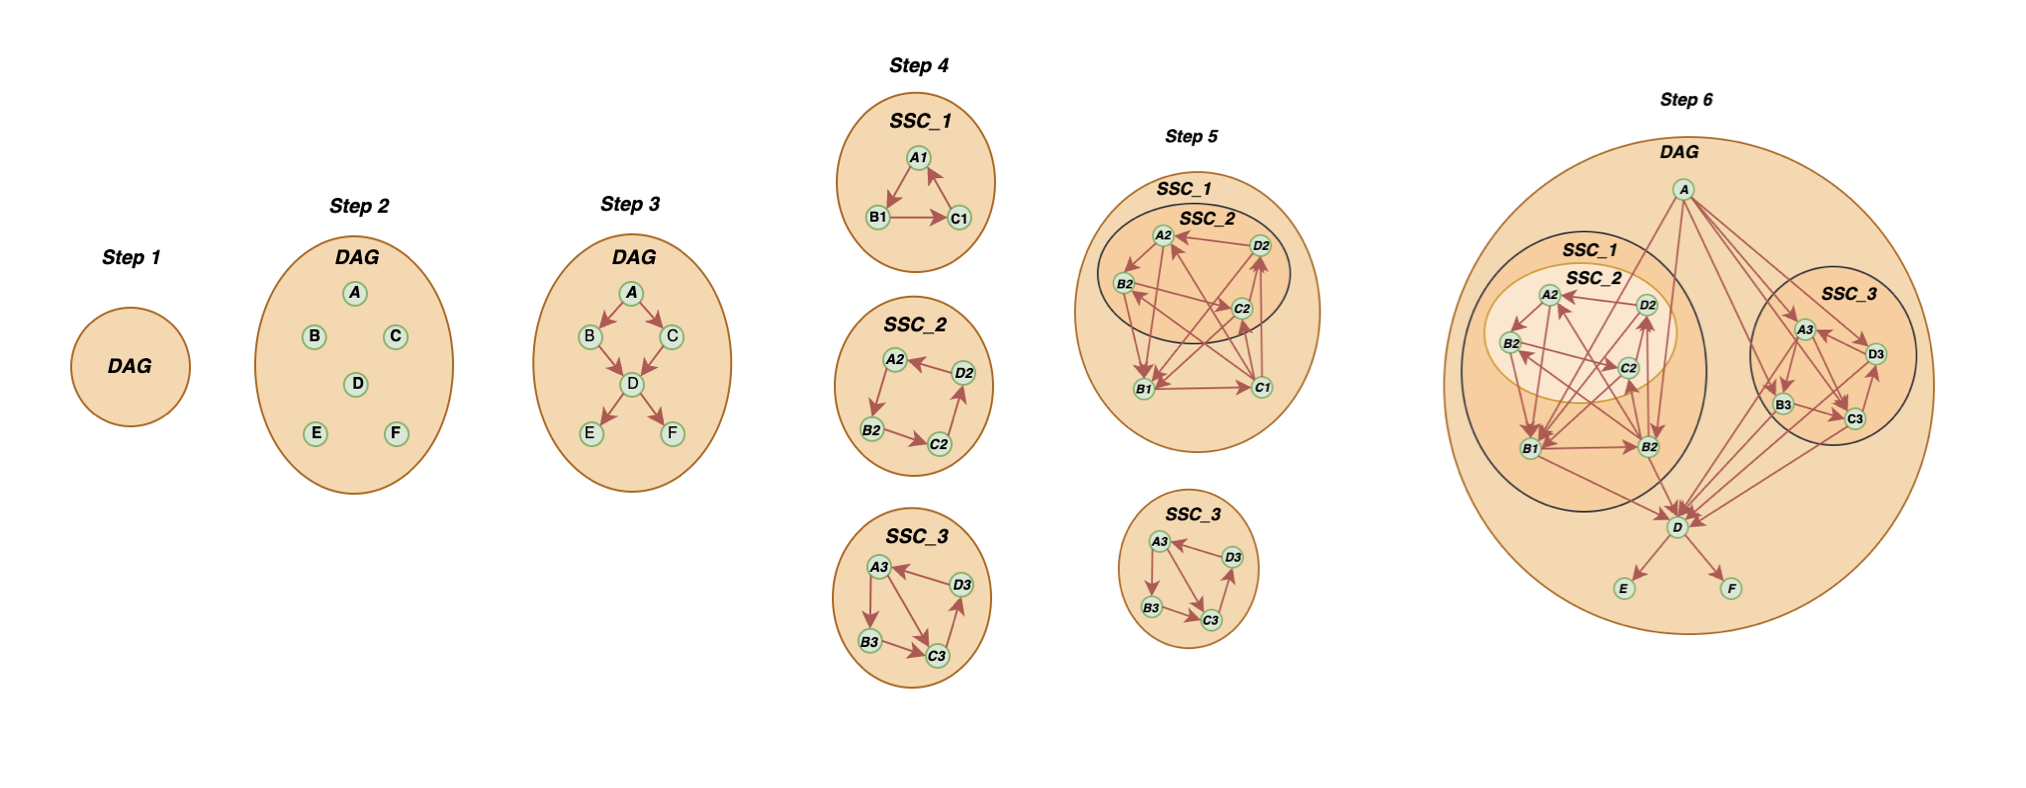
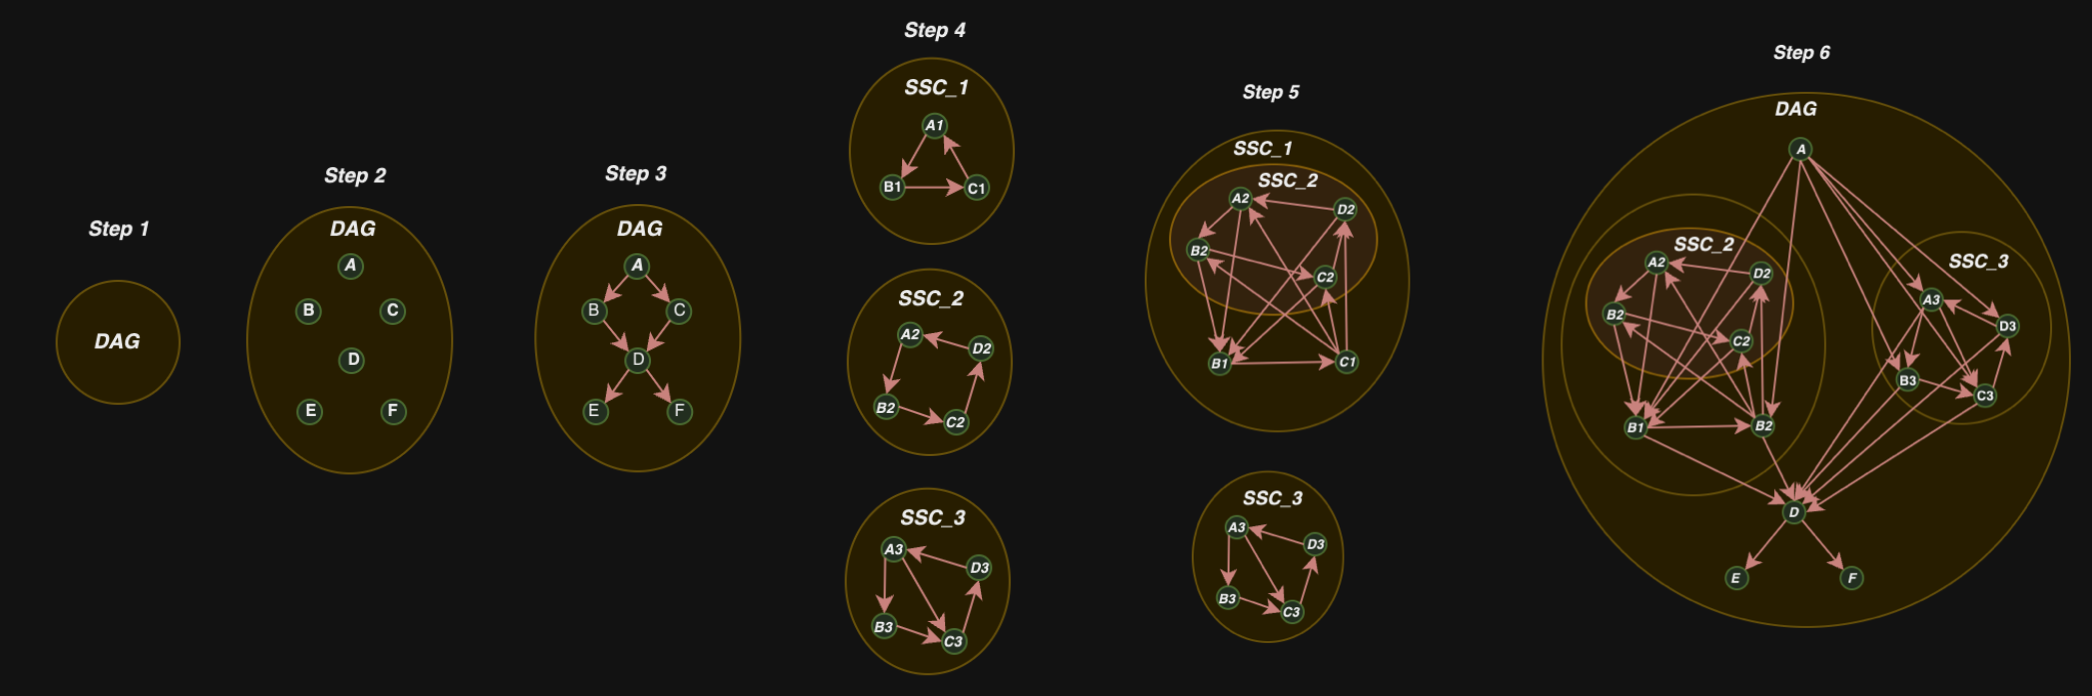
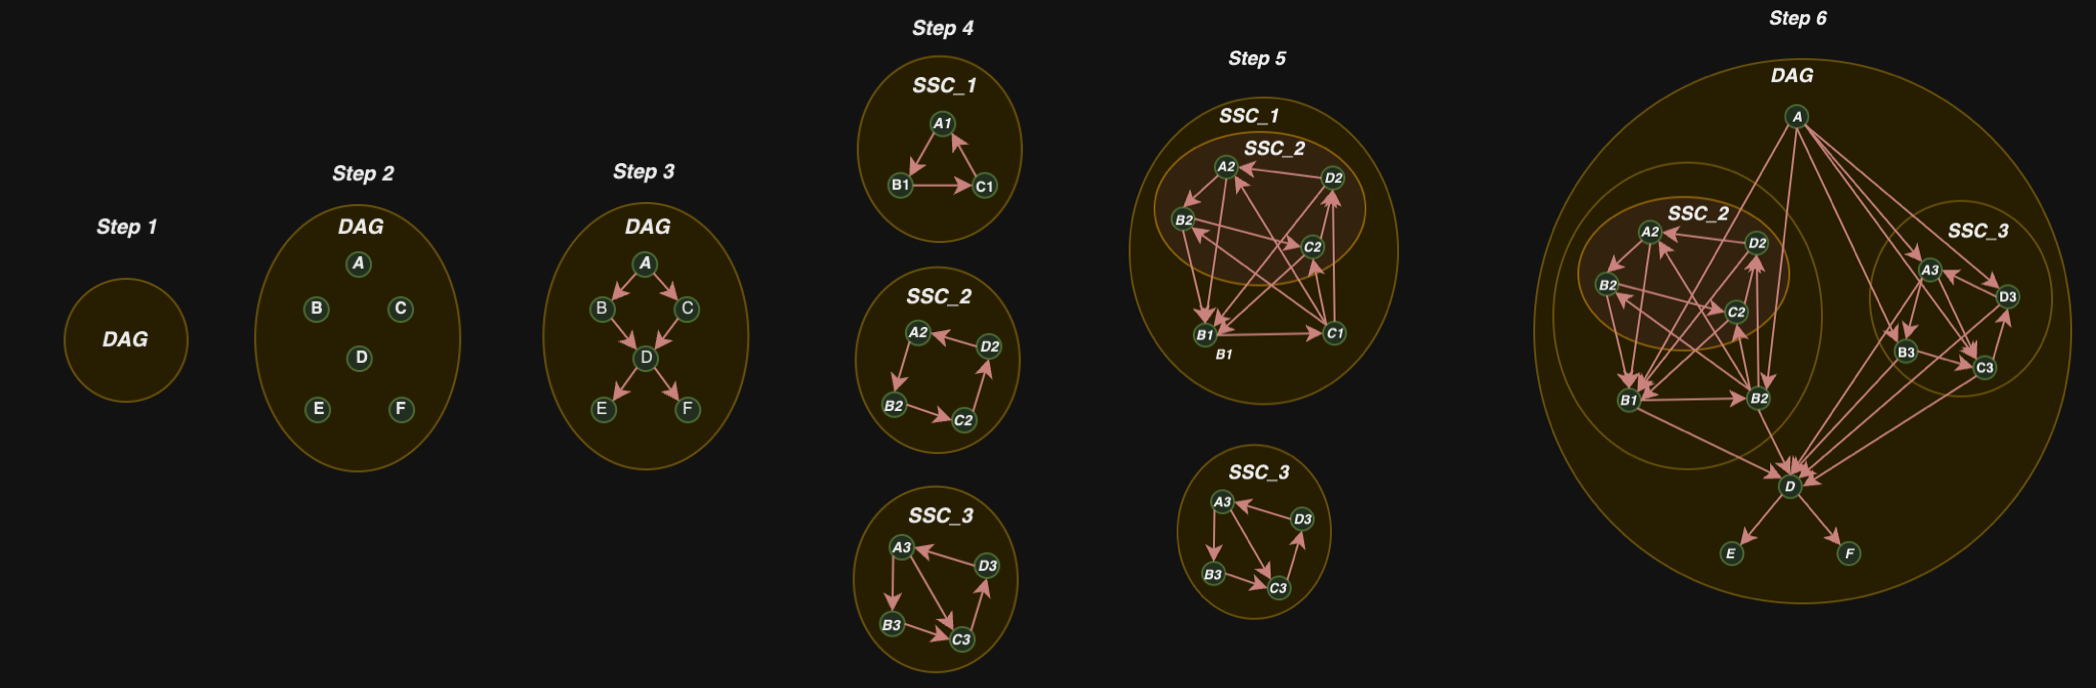


<span style="font-size: 22px;">On the other hand, lets assume developer received JSON created in previous steps (DAG).</span>

<span style="font-size: 15px;">Developer task description:</span>
- <span style="font-size: 15px;">extract strongly connected components JSONs for other team.</span>
- <span style="font-size: 15px;">create simple test cases (path coverage), where every SSC is covered by one path.</span>

<span style="font-size: 20px;">Received JSON representation:</span>
```
{
"DAG": {
    "A": [{"SSC_1": ["C1", "B1"]}, {"SSC_3": ["C3", "A3", "B3", "D3"]}],
    "SSC_3": {
        "C3": ["D3", {"DAG": ["D"]}],
        "A3": ["B3", "C3", {"DAG": ["D"]}],
        "B3": ["C3", {"DAG": ["D"]}],
        "D3": ["A3", {"DAG": ["D"]}],
    },
    "F": [],
    "E": [],
    "D": ["E", "F"],
    "SSC_1": {
        "SSC_2": {
            "A2": ["B2", {"SSC_1": ["B1"]}],
            "C2": ["D2", {"SSC_1": ["B1"]}],
            "D2": ["A2", {"SSC_1": ["B1"]}],
            "B2": ["C2", {"SSC_1": ["B1"]}],
        },
        "C1": [{"SSC_2": ["A2", "C2", "D2", "B2"]}, {"DAG": ["D"]}],
        "B1": ["C1", {"DAG": ["D"]}],
    },
},
}
```

In [6]:
#let's assume we want to test SSC_1 as a subsystem of the digraph
from diblob import cut_outgoing_edges

json_repr = cut_outgoing_edges(digraph, 'SSC_1')
subsystem = dib.DigraphManager(json_repr)
subsystem.flatten('SSC_2')

print(subsystem)

{
"SSC_1": {
    "B2": ["C2", "B1"],
    "B1": ["C1"],
    "A2": ["B2", "B1"],
    "D2": ["A2", "B1"],
    "C2": ["D2", "B1"],
    "C1": ["A2", "C2", "B2", "D2"],
},
}



In [7]:
#There is need to add source S and sink T for testing purposes
subsystem.add_nodes('S', 'T')
subsystem.connect_nodes(('S', 'B1'), ('S', 'B2'), ('B1', 'T'), ('B2', 'T'))
print(subsystem)


{
"SSC_1": {
    "S": ["B1", "B2"],
    "B2": ["C2", "B1", "T"],
    "B1": ["C1", "T"],
    "A2": ["B2", "B1"],
    "D2": ["A2", "B1"],
    "T": [],
    "C2": ["D2", "B1"],
    "C1": ["A2", "C2", "B2", "D2"],
},
}



In [9]:
from testing_criterions.NodeCoverage import NodeCoverage
from testing_criterions.EdgeCoverage import EdgeCoverage
from testing_criterions.SimpleCycleCoverage import SimpleCycleCoverage

print("#### NODE COVERAGE ####")
node_cover = NodeCoverage(subsystem)
for test_case in node_cover.get_test_cases():
    print(test_case)

print("#### EDGE COVERAGE ####")
edge_cover = EdgeCoverage(subsystem)
print(edge_cover.get_test_cases_minimal_number_of_test_cases())

print("#### SIMPLE CYCLE COVERAGE ####")
simple_cover = SimpleCycleCoverage(subsystem)
for test_case in simple_cover.get_test_cases(10):
    print(test_case)

#### NODE COVERAGE ####
['S', 'B1', 'C1', 'A2', 'B2', 'C2', 'D2', 'B1', 'T']
['S', 'B1', 'C1', 'A2', 'B2', 'T']
#### EDGE COVERAGE ####
[['S', 'B1', 'C1', 'A2', 'B1', 'C1', 'D2', 'A2', 'B2', 'B1', 'C1', 'C2', 'D2', 'B1', 'C1', 'B2', 'C2', 'B1', 'T'], ['S', 'B2', 'T']]
#### SIMPLE CYCLE COVERAGE ####
['S', 'B1', 'C1', 'A2', 'B2', 'C2', 'D2', 'A2', 'B2', 'C2', 'D2', 'B1', 'C1', 'A2', 'B2', 'C2', 'B1', 'C1', 'A2', 'B2', 'C2', 'B1', 'C1', 'D2', 'A2', 'B2', 'B1', 'C1', 'A2', 'B2', 'B1', 'C1', 'C2', 'D2', 'A2', 'B2', 'B1', 'C1', 'D2', 'A2', 'B1', 'C1', 'A2', 'B1', 'C1', 'C2', 'D2', 'A2', 'B1', 'C1', 'B2', 'C2', 'D2', 'A2', 'B1', 'T']
['S', 'B1', 'C1', 'A2', 'B1', 'C1', 'D2', 'A2', 'B1', 'C1', 'C2', 'D2', 'B1', 'C1', 'C2', 'B1', 'C1', 'B2', 'C2', 'D2', 'B1', 'C1', 'B2', 'C2', 'B1', 'C1', 'B2', 'B1', 'C1', 'D2', 'B1', 'T']
